# Customer Behavior Classification

This notebook classifies customers into 5 distinct shopper classes based on their purchasing behavior.

## Objectives:
1. Load and merge customer, order, and sales data
2. Create behavioral features
3. Classify customers into 5 shopper classes
4. Normalize data using best practices
5. Train multiple ML models (KNN, SVM) with grid search
6. Compare model performance with visualizations


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## Step 1: Load Data


In [2]:
# Load all three datasets
customers_df = pd.read_excel('C:/Users/GSI/Desktop/DataWareHouse/Customers_f.xlsx')
orders_df = pd.read_excel('C:/Users/GSI/Desktop/DataWareHouse/Orders.xlsx')
sales_df = pd.read_excel('C:/Users/GSI/Desktop/DataWareHouse/Sales.xlsx')

print("Data loaded successfully!")
print(f"\nCustomers shape: {customers_df.shape}")
print(f"Orders shape: {orders_df.shape}")
print(f"Sales shape: {sales_df.shape}")

# Display first few rows
print("\n=== Customers Data ===")
print(customers_df.head())
print("\n=== Orders Data ===")
print(orders_df.head())
print("\n=== Sales Data ===")
print(sales_df.head())


Data loaded successfully!

Customers shape: (3900, 10)
Orders shape: (500, 3)
Sales shape: (502500, 12)

=== Customers Data ===
   code_customer  Age Gender                   Zip_code Preferred_size  \
0              1   55   Male         Lexington_Kentucky              L   
1              2   19   Male               Auburn_Maine              L   
2              3   50   Male  Springfield_Massachusetts              S   
3              4   21   Male      Cranston_Rhode Island              M   
4              5   45   Male              Eugene_Oregon              M   

   Overall_review Subscription Status  Previous Purchases Payment Method  \
0             3.1                 Yes                  14          Venmo   
1             3.1                 Yes                   2           Cash   
2             3.1                 Yes                  23    Credit Card   
3             3.5                 Yes                  49         PayPal   
4             2.7                 Yes          

## Step 2: Data Preprocessing and Feature Engineering


In [3]:
# Clean and preprocess data
# Fix decimal separator in Overall_review (comma to dot)
if 'Overall_review' in customers_df.columns:
    customers_df['Overall_review'] = customers_df['Overall_review'].astype(str).str.replace(',', '.').astype(float)

# Fix decimal separator in Estimated_Unit_Price
if 'Estimated_Unit_Price' in sales_df.columns:
    sales_df['Estimated_Unit_Price'] = sales_df['Estimated_Unit_Price'].astype(str).str.replace(',', '.').astype(float)

# Convert sale_date to datetime
if 'sale_date' in sales_df.columns:
    sales_df['sale_date'] = pd.to_datetime(sales_df['sale_date'])

print("Data preprocessing completed!")


Data preprocessing completed!


In [7]:
# Merge order status with sales
sales_with_status = sales_df.merge(order_status_features, left_on='code_order', right_on='order_code', how='left')

# Calculate return/cancel rate per customer
customer_order_stats = sales_with_status.groupby('code_customer').agg({
    'status_label': lambda x: (x == 'Returned').sum() + (x == 'Cancelled').sum(),
    'code_sale': 'count'
}).reset_index()
customer_order_stats.columns = ['code_customer', 'returned_cancelled', 'total_orders']
customer_order_stats['return_cancel_rate'] = customer_order_stats['returned_cancelled'] / customer_order_stats['total_orders']

# Merge with customer features
customer_features = customer_features.merge(customer_order_stats[['code_customer', 'return_cancel_rate']], 
                                            on='code_customer', how='left')
customer_features['return_cancel_rate'] = customer_features['return_cancel_rate'].fillna(0)

## Step 3: Define 5 Customer Classes Based on Behavior

We'll classify customers into 5 classes:
1. **VIP Shoppers**: High spending, frequent purchases, low returns
2. **Regular Loyalists**: Moderate spending, consistent purchases, loyal
3. **Bargain Hunters**: High discount usage, moderate spending
4. **Occasional Buyers**: Low frequency, low spending
5. **Problem Customers**: High return/cancel rate, potential issues


In [8]:
def classify_customer(row):
    """
    Classify customers into 5 classes:
    0: Occasional Buyers
    1: Regular Loyalists
    2: Bargain Hunters
    3: VIP Shoppers
    4: Problem Customers
    """
    total_spent = row['total_spent']
    purchase_freq = row['purchase_frequency']
    discount_rate = row['discount_rate']
    return_rate = row['return_cancel_rate']
    total_purchases = row['total_purchases']
   
    # Calculate thresholds (use quantiles from the full dataset)
    spent_75 = customer_features['total_spent'].quantile(0.75)
    spent_25 = customer_features['total_spent'].quantile(0.25)
    freq_75 = customer_features['purchase_frequency'].quantile(0.75)
    freq_50 = customer_features['purchase_frequency'].quantile(0.50)
   
    # Problem Customers: High return/cancel rate
    if return_rate > 0.3:
        return 4  # Problem Customers
   
    # VIP Shoppers: High spending, high frequency, low returns
    if total_spent >= spent_75 and purchase_freq >= freq_75 and return_rate < 0.1:
        return 3  # VIP Shoppers
   
    # Bargain Hunters: High discount usage, moderate spending
    if discount_rate > 0.6 and total_purchases >= 3:
        return 2  # Bargain Hunters
   
    # Regular Loyalists: Moderate spending, consistent purchases
    if purchase_freq >= freq_50 and total_purchases >= 5 and total_spent >= spent_25:
        return 1  # Regular Loyalists
   
    # Occasional Buyers: Everyone else (low frequency, low spending)
    return 0  # Occasional Buyers

# Apply classification
customer_features['customer_class'] = customer_features.apply(classify_customer, axis=1)

# Map class numbers to names
class_names = {
    0: 'Occasional Buyers',
    1: 'Regular Loyalists',
    2: 'Bargain Hunters',
    3: 'VIP Shoppers',
    4: 'Problem Customers'
}

customer_features['class_name'] = customer_features['customer_class'].map(class_names)

# Display class distribution
print("Customer Class Distribution:")
print(customer_features['class_name'].value_counts())
print("\nClass Distribution Percentage:")
print(customer_features['class_name'].value_counts(normalize=True) * 100)


Customer Class Distribution:
class_name
Occasional Buyers    1973
Regular Loyalists    1907
Problem Customers      20
Name: count, dtype: int64

Class Distribution Percentage:
class_name
Occasional Buyers    50.589744
Regular Loyalists    48.897436
Problem Customers     0.512821
Name: proportion, dtype: float64


## Step 4: Prepare Features for Machine Learning


In [10]:
# Select features for ML model
# Numerical features
numerical_features = [
    'total_purchases', 'total_quantity', 'avg_unit_price', 'total_spent',
    'discount_rate', 'customer_lifetime_days', 'purchase_frequency',
    'avg_order_value', 'return_cancel_rate', 'Age', 'Overall_review',
    'Previous Purchases'
]

# Categorical features to encode
categorical_features = ['Gender', 'Preferred_size', 'Payment Method', 'Frequency of Purchases']

# Create feature dataframe
X = customer_features[numerical_features].copy()

# Handle missing values
X = X.fillna(X.median())

# Encode categorical features
le_dict = {}
for col in categorical_features:
    if col in customer_features.columns:
        le = LabelEncoder()
        X[col + '_encoded'] = le.fit_transform(customer_features[col].fillna('Unknown'))
        le_dict[col] = le

# Target variable
y = customer_features['customer_class']

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used: {X.columns.tolist()}")
print(f"\nClass distribution:\n{y.value_counts().sort_index()}")


Feature matrix shape: (3900, 16)
Target shape: (3900,)

Features used: ['total_purchases', 'total_quantity', 'avg_unit_price', 'total_spent', 'discount_rate', 'customer_lifetime_days', 'purchase_frequency', 'avg_order_value', 'return_cancel_rate', 'Age', 'Overall_review', 'Previous Purchases', 'Gender_encoded', 'Preferred_size_encoded', 'Payment Method_encoded', 'Frequency of Purchases_encoded']

Class distribution:
customer_class
0    1973
1    1907
4      20
Name: count, dtype: int64


## Step 5: Data Normalization (Best Practices)


In [11]:
# Split data before normalization (to prevent data leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Normalize using StandardScaler (best practice for distance-based and SVM models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("\nData normalized using StandardScaler (Z-score normalization)")
print("This ensures all features have mean=0 and std=1")
print(f"\nScaled training data statistics:")
print(X_train_scaled_df.describe().round(2))


Training set size: (3120, 16)
Test set size: (780, 16)

Data normalized using StandardScaler (Z-score normalization)
This ensures all features have mean=0 and std=1

Scaled training data statistics:
       total_purchases  total_quantity  avg_unit_price  total_spent  \
count          3120.00         3120.00         3120.00      3120.00   
mean              0.00           -0.00            0.00         0.00   
std               1.00            1.00            1.00         1.00   
min              -3.34           -3.47           -2.98        -3.48   
25%              -0.69           -0.70           -0.68        -0.69   
50%               0.01           -0.02           -0.03        -0.01   
75%               0.63            0.66            0.65         0.65   
max               3.80            3.15            3.97         3.73   

       discount_rate  customer_lifetime_days  purchase_frequency  \
count        3120.00                 3120.00             3120.00   
mean           -0.00     

## Step 6: Visualize Normalized Data


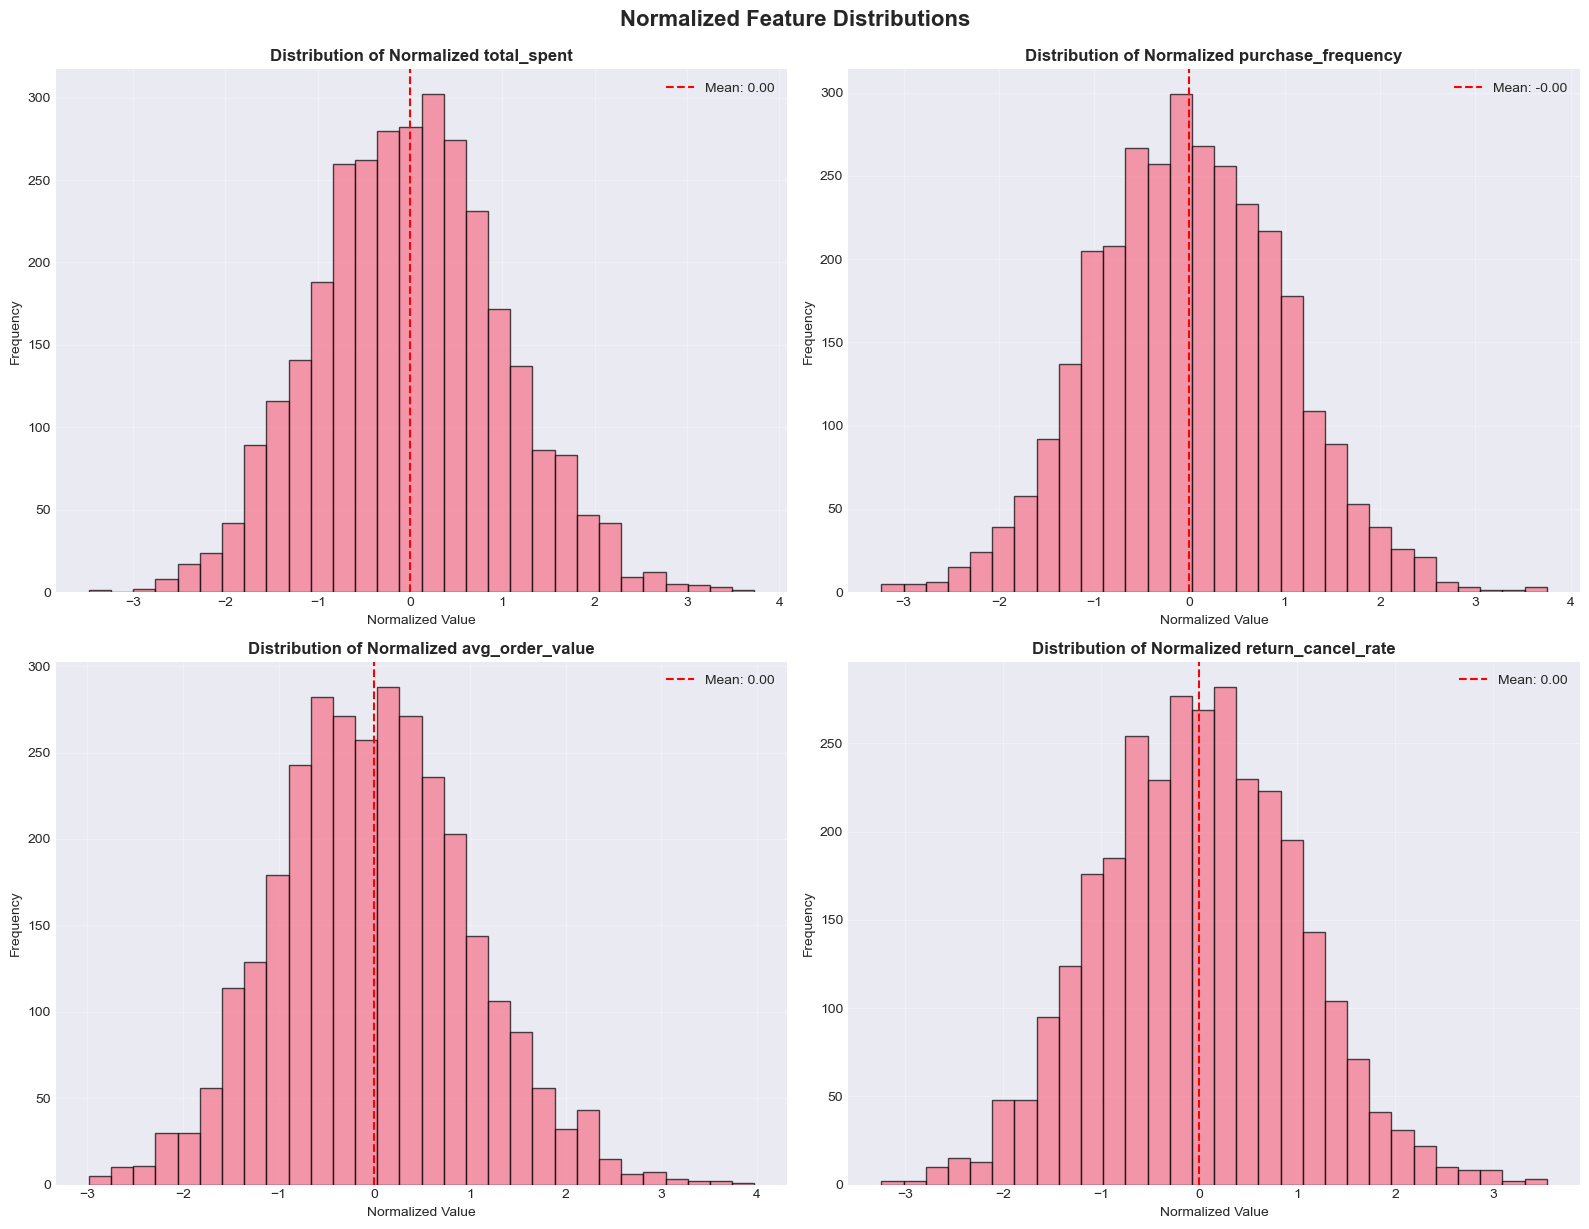

In [12]:
# Visualize normalized data distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of normalized features
selected_features = ['total_spent', 'purchase_frequency', 'avg_order_value', 'return_cancel_rate']
for idx, feature in enumerate(selected_features):
    ax = axes[idx // 2, idx % 2]
    X_train_scaled_df[feature].hist(bins=30, ax=ax, alpha=0.7, edgecolor='black')
    ax.set_title(f'Distribution of Normalized {feature}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Normalized Value')
    ax.set_ylabel('Frequency')
    ax.axvline(X_train_scaled_df[feature].mean(), color='red', linestyle='--', 
               label=f'Mean: {X_train_scaled_df[feature].mean():.2f}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Normalized Feature Distributions', fontsize=16, fontweight='bold', y=1.02)
plt.show()


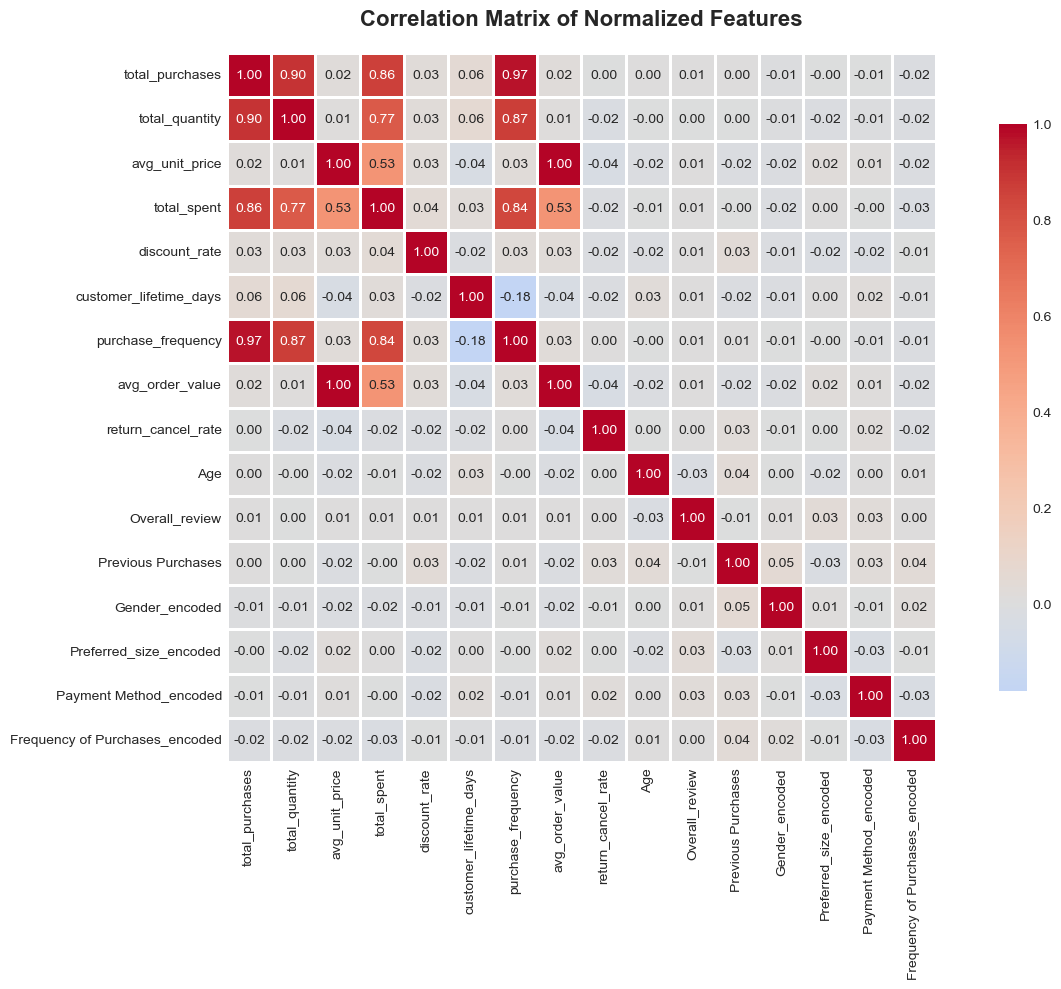

In [13]:
# Correlation heatmap of normalized features
plt.figure(figsize=(14, 10))
correlation_matrix = X_train_scaled_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Normalized Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


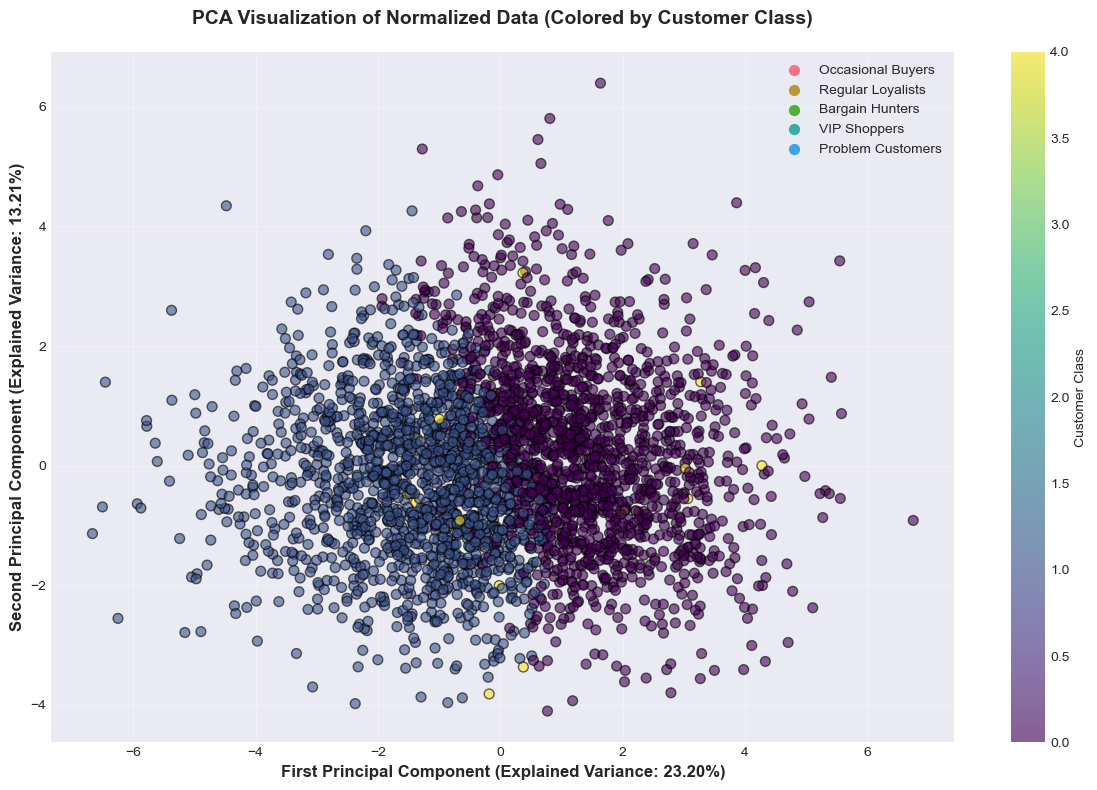

Total explained variance by first 2 components: 36.41%


In [14]:
# PCA visualization (2D projection of normalized data)
from sklearn.decomposition import PCA

# Apply PCA for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled_df)

# Create scatter plot colored by class
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                     c=y_train, cmap='viridis', alpha=0.6, s=50, edgecolors='black')
plt.colorbar(scatter, label='Customer Class')
plt.xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})', 
           fontsize=12, fontweight='bold')
plt.ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})', 
           fontsize=12, fontweight='bold')
plt.title('PCA Visualization of Normalized Data (Colored by Customer Class)', 
          fontsize=14, fontweight='bold', pad=20)
plt.grid(alpha=0.3)

# Add legend
for class_num, class_name in class_names.items():
    plt.scatter([], [], label=class_name, s=50)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print(f"Total explained variance by first 2 components: {pca.explained_variance_ratio_.sum():.2%}")


## Step 7: Scalable Model Architecture

We'll create a scalable system that makes it easy to add more models.


In [15]:
# Scalable model configuration using dataclass
from dataclasses import dataclass
from typing import Any, Dict

@dataclass
class ModelConfig:
    """Configuration class for ML models"""
    name: str
    model: Any
    param_grid: Dict[str, list]
    best_model: Any = None
    best_params: Dict = None
    best_score: float = None

# Initialize model configurations
models_config = [
    ModelConfig(
        name='K-Nearest Neighbors (KNN)',
        model=KNeighborsClassifier(),
        param_grid={
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    ),
    ModelConfig(
        name='Support Vector Machine (SVM)',
        model=SVC(random_state=42),
        param_grid={
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto', 0.001, 0.01]
        }
    )
]

print("Model configurations created!")
print(f"Total models: {len(models_config)}")
for cfg in models_config:
    print(f"  - {cfg.name}")


Model configurations created!
Total models: 2
  - K-Nearest Neighbors (KNN)
  - Support Vector Machine (SVM)


## Step 8: Train Models with Grid Search


In [16]:
# ============================================================================
# CELL 8: Model Training with Comprehensive Safety Checks
# ============================================================================

# Check class distribution in training set
print("Class distribution in training set:")
print(y_train.value_counts().sort_index())
print(f"\nTotal samples: {len(y_train)}")
print(f"Number of classes: {y_train.nunique()}")

# ============================================================================
# SAFETY CHECK: Verify we have multiple classes
# ============================================================================
if y_train.nunique() < 2:
    print("\n" + "="*80)
    print("ERROR: Training set contains only 1 class!")
    print("="*80)
    print("\nYou need to redo your train-test split with stratification.")
    print("Add this BEFORE your train-test split:\n")
    print("from sklearn.model_selection import train_test_split")
    print("X_train, X_test, y_train, y_test = train_test_split(")
    print("    X, y,")
    print("    test_size=0.2,")
    print("    random_state=42,")
    print("    stratify=y  # THIS IS CRITICAL!")
    print(")")
    print("\n" + "="*80)
    raise ValueError("Cannot proceed with only 1 class in training data. Please fix the train-test split.")

# Check test set too
print("\nClass distribution in test set:")
print(y_test.value_counts().sort_index())
print(f"Test samples: {len(y_test)}")
print(f"Test classes: {y_test.nunique()}")

# ============================================================================
# Use StratifiedKFold for cross-validation
# ============================================================================
# This ensures all classes are present in each fold
# Prevents "only one class" errors during cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dictionary to store results
results = {}

# ============================================================================
# Train each model with grid search
# ============================================================================
for model_cfg in models_config:
    print(f"\n{'='*80}")
    print(f"Training {model_cfg.name}")
    print(f"{'='*80}")
    
    try:
        # Grid search with stratified cross-validation
        # StratifiedKFold ensures each fold has all classes present
        grid_search = GridSearchCV(
            estimator=model_cfg.model,
            param_grid=model_cfg.param_grid,
            cv=skf,  # Use StratifiedKFold instead of integer
            scoring='accuracy',
            n_jobs=-1,  # Use all available cores
            verbose=1
        )
        
        # Fit the model
        grid_search.fit(X_train_scaled_df, y_train)
        
        # Store best model and parameters
        model_cfg.best_model = grid_search.best_estimator_
        model_cfg.best_params = grid_search.best_params_
        model_cfg.best_score = grid_search.best_score_
        
        # Make predictions
        y_pred_train = model_cfg.best_model.predict(X_train_scaled_df)
        y_pred_test = model_cfg.best_model.predict(X_test_scaled_df)
        
        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, y_pred_train)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        
        # Store results
        results[model_cfg.name] = {
            'best_params': model_cfg.best_params,
            'cv_score': model_cfg.best_score,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'y_pred_test': y_pred_test,
            'y_pred_train': y_pred_train
        }
        
        print(f"\nBest parameters: {model_cfg.best_params}")
        print(f"Best CV score: {model_cfg.best_score:.4f}")
        print(f"Train accuracy: {train_accuracy:.4f}")
        print(f"Test accuracy: {test_accuracy:.4f}")
        
    except Exception as e:
        print(f"\n❌ ERROR training {model_cfg.name}:")
        print(f"   {str(e)}")
        print(f"   Skipping this model...\n")
        continue

print(f"\n{'='*80}")
print("Training completed!")
print(f"{'='*80}")
print(f"Successfully trained models: {len(results)}/{len(models_config)}")

Class distribution in training set:
customer_class
0    1578
1    1526
4      16
Name: count, dtype: int64

Total samples: 3120
Number of classes: 3

Class distribution in test set:
customer_class
0    395
1    381
4      4
Name: count, dtype: int64
Test samples: 780
Test classes: 3

Training K-Nearest Neighbors (KNN)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best CV score: 0.9455
Train accuracy: 1.0000
Test accuracy: 0.9462

Training Support Vector Machine (SVM)
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV score: 0.9763
Train accuracy: 0.9804
Test accuracy: 0.9705

Training completed!
Successfully trained models: 2/2


## Step 9: Model Comparison Visualizations


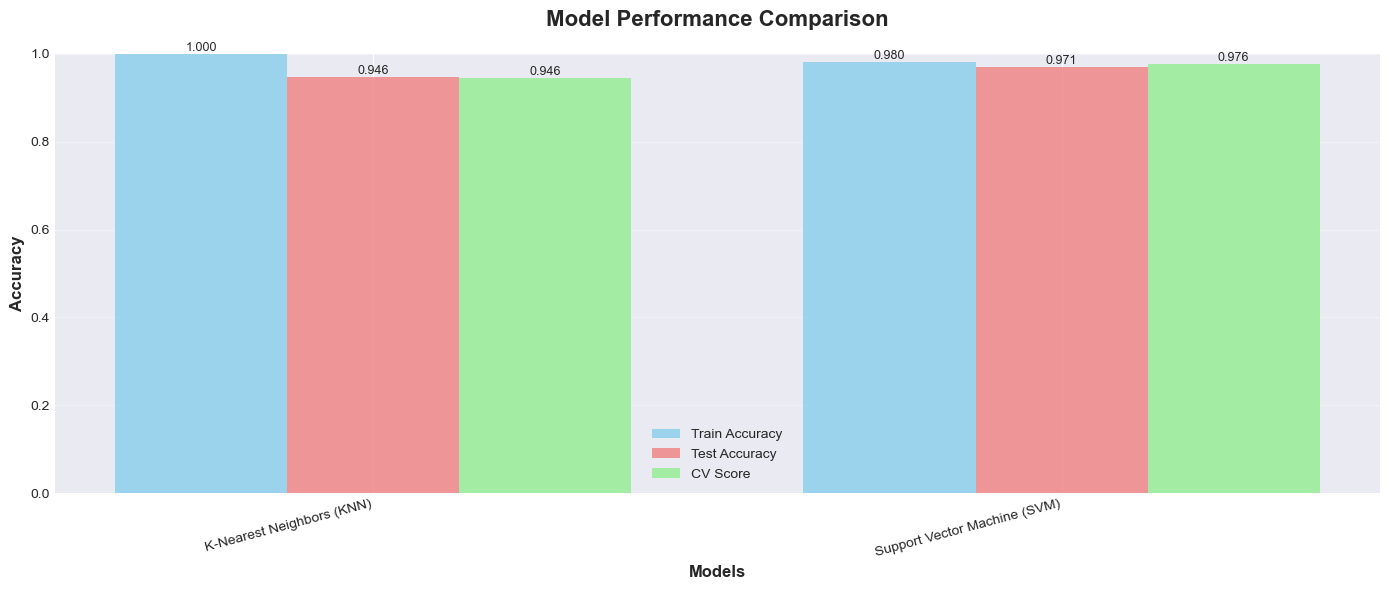

In [17]:
# 1. Model Performance Comparison Bar Chart
model_names = list(results.keys())
train_accuracies = [results[m]['train_accuracy'] for m in model_names]
test_accuracies = [results[m]['test_accuracy'] for m in model_names]
cv_scores = [results[m]['cv_score'] for m in model_names]

x = np.arange(len(model_names))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width, train_accuracies, width, label='Train Accuracy', alpha=0.8, color='skyblue')
bars2 = ax.bar(x, test_accuracies, width, label='Test Accuracy', alpha=0.8, color='lightcoral')
bars3 = ax.bar(x + width, cv_scores, width, label='CV Score', alpha=0.8, color='lightgreen')

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


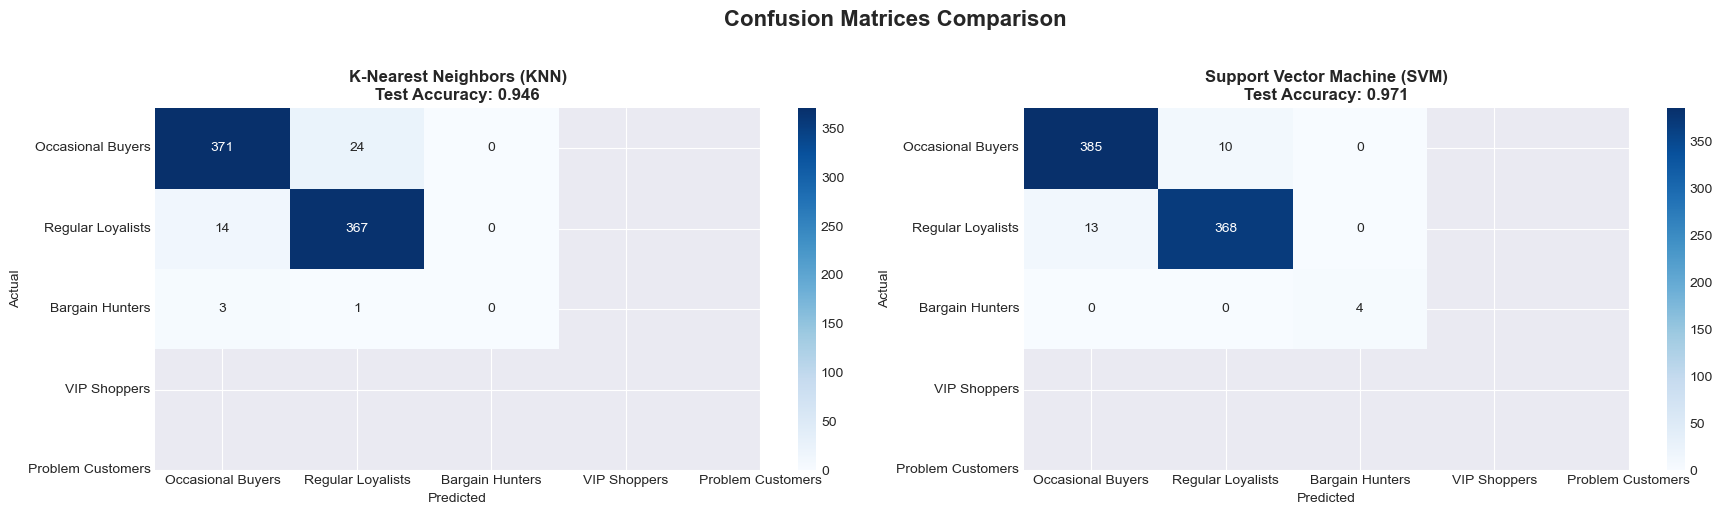

In [18]:
# 2. Confusion Matrices for each model
fig, axes = plt.subplots(1, len(model_names), figsize=(18, 5))

for idx, model_name in enumerate(model_names):
    cm = confusion_matrix(y_test, results[model_name]['y_pred_test'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=[class_names[i] for i in sorted(class_names.keys())],
                yticklabels=[class_names[i] for i in sorted(class_names.keys())])
    axes[idx].set_title(f'{model_name}\nTest Accuracy: {results[model_name]["test_accuracy"]:.3f}', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_ylabel('Actual', fontsize=10)

plt.suptitle('Confusion Matrices Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


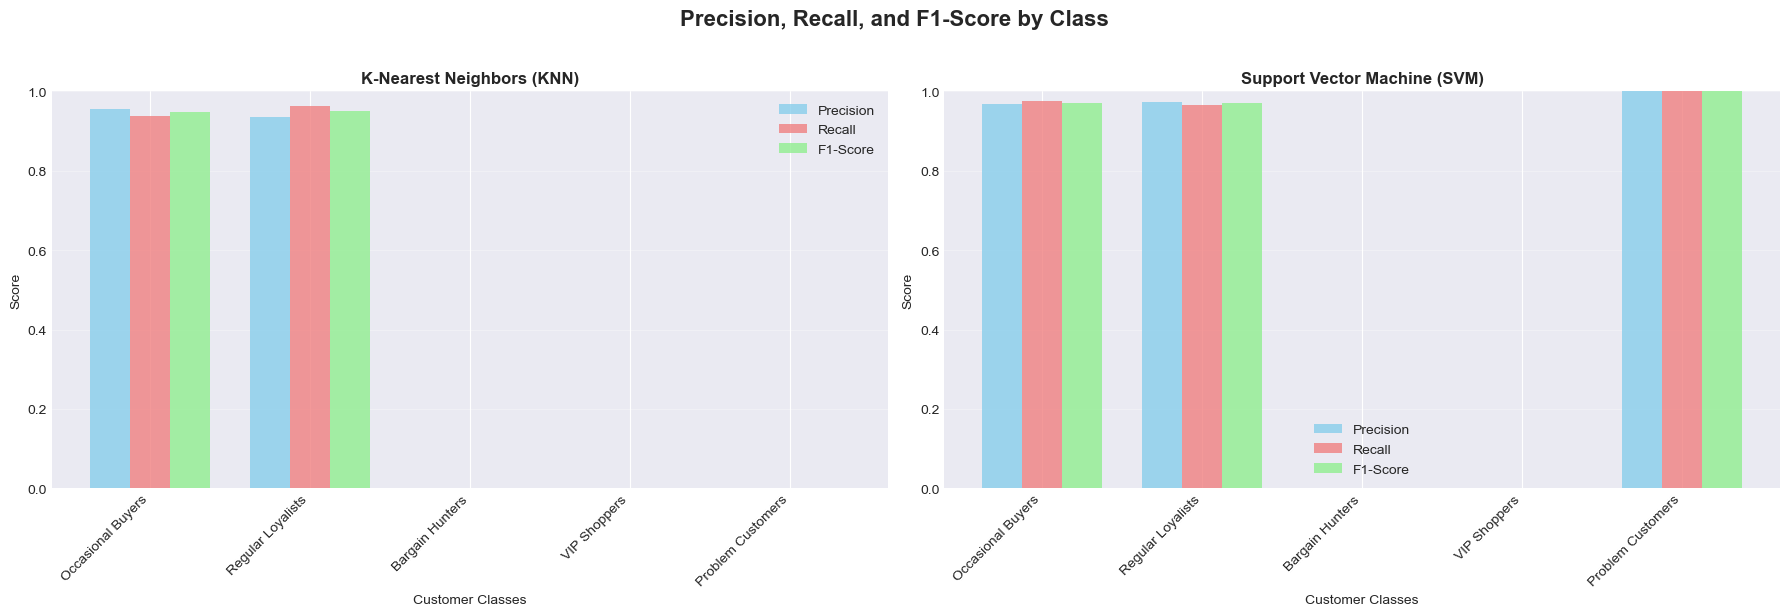

In [19]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

# 1. Get the specific list of label IDs from your class_names dictionary
# Assuming class_names is {0: 'Name', 1: 'Name', ...}
target_labels = sorted(class_names.keys()) 

fig, axes = plt.subplots(1, len(model_names), figsize=(18, 6))

# If there is only one model, axes is not a list, so we ensure it is iterable
if len(model_names) == 1:
    axes = [axes]

for idx, model_name in enumerate(model_names):
    # 2. Add the 'labels' and 'zero_division' arguments here
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, 
        results[model_name]['y_pred_test'], 
        average=None,
        labels=target_labels,  # <--- FORCES METRICS FOR ALL 5 CLASSES
        zero_division=0        # <--- Sets score to 0 instead of Error/Warning for missing classes
    )
    
    x_pos = np.arange(len(class_names))
    width = 0.25
    
    # Now precision, recall, and f1 will all have shape (5,), matching x_pos
    axes[idx].bar(x_pos - width, precision, width, label='Precision', alpha=0.8, color='skyblue')
    axes[idx].bar(x_pos, recall, width, label='Recall', alpha=0.8, color='lightcoral')
    axes[idx].bar(x_pos + width, f1, width, label='F1-Score', alpha=0.8, color='lightgreen')
    
    axes[idx].set_xlabel('Customer Classes', fontsize=10)
    axes[idx].set_ylabel('Score', fontsize=10)
    axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels([class_names[i] for i in target_labels], 
                              rotation=45, ha='right')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([0, 1])

plt.suptitle('Precision, Recall, and F1-Score by Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [20]:
# 4. Detailed Performance Metrics Table
print("\n" + "="*100)
print("DETAILED MODEL PERFORMANCE COMPARISON")
print("="*100)

comparison_df = pd.DataFrame({
    'Model': model_names,
    'CV Score': cv_scores,
    'Train Accuracy': train_accuracies,
    'Test Accuracy': test_accuracies,
    'Overfitting (Train-Test Diff)': [train - test for train, test in zip(train_accuracies, test_accuracies)]
})

comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
print("\n", comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n{'='*100}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {comparison_df.iloc[0]['Test Accuracy']:.4f}")
print(f"   CV Score: {comparison_df.iloc[0]['CV Score']:.4f}")
print(f"{'='*100}")



DETAILED MODEL PERFORMANCE COMPARISON

                        Model  CV Score  Train Accuracy  Test Accuracy  Overfitting (Train-Test Diff)
Support Vector Machine (SVM)  0.976282        0.980449       0.970513                       0.009936
   K-Nearest Neighbors (KNN)  0.945513        1.000000       0.946154                       0.053846

🏆 BEST MODEL: Support Vector Machine (SVM)
   Test Accuracy: 0.9705
   CV Score: 0.9763


In [21]:
from sklearn.metrics import classification_report

# 1. Define the full list of label IDs
all_labels = sorted(class_names.keys())  # e.g., [0, 1, 2, 3, 4]

# 2. Define the corresponding names
all_names = [class_names[i] for i in all_labels]

for model_name in model_names:
    print(f"\n{'='*80}")
    print(f"Classification Report: {model_name}")
    print(f"{'='*80}")
    
    print(classification_report(
        y_test, 
        results[model_name]['y_pred_test'],
        labels=all_labels,       # <--- CRITICAL FIX: Forces report for all 5 classes
        target_names=all_names,  # <--- Matches the 5 labels provided above
        zero_division=0          # <--- Sets metrics to 0.0 for missing classes instead of warning
    ))


Classification Report: K-Nearest Neighbors (KNN)
                   precision    recall  f1-score   support

Occasional Buyers       0.96      0.94      0.95       395
Regular Loyalists       0.94      0.96      0.95       381
  Bargain Hunters       0.00      0.00      0.00         0
     VIP Shoppers       0.00      0.00      0.00         0
Problem Customers       0.00      0.00      0.00         4

        micro avg       0.95      0.95      0.95       780
        macro avg       0.38      0.38      0.38       780
     weighted avg       0.94      0.95      0.94       780


Classification Report: Support Vector Machine (SVM)
                   precision    recall  f1-score   support

Occasional Buyers       0.97      0.97      0.97       395
Regular Loyalists       0.97      0.97      0.97       381
  Bargain Hunters       0.00      0.00      0.00         0
     VIP Shoppers       0.00      0.00      0.00         0
Problem Customers       1.00      1.00      1.00         4

       

Adding Random Forest

Added Random Forest model. Total models: 3

Now running grid search for Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Random Forest Results:
Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Best CV score: 0.9978
Test accuracy: 0.9949


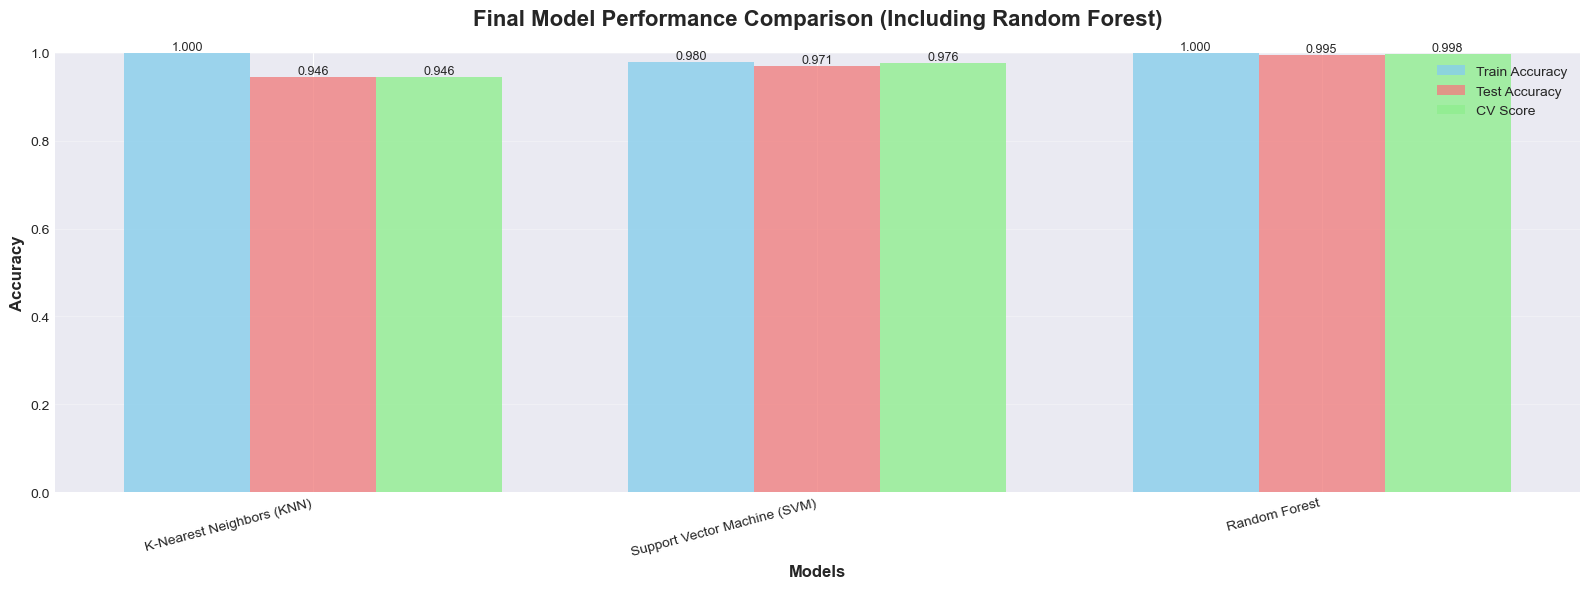


All models trained successfully!


In [22]:
# Example: Adding Random Forest to demonstrate scalability
from sklearn.ensemble import RandomForestClassifier

# Add Random Forest model
models_config.append(
    ModelConfig(
        name='Random Forest',
        model=RandomForestClassifier(random_state=42),
        param_grid={
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
    )
)

print(f"Added Random Forest model. Total models: {len(models_config)}")
print("\nNow running grid search for Random Forest...")

# Run grid search for the new model
model_cfg = models_config[-1]
grid_search = GridSearchCV(
    estimator=model_cfg.model,
    param_grid=model_cfg.param_grid,
    cv=skf,  # Use StratifiedKFold (already defined above)
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled_df, y_train)

model_cfg.best_model = grid_search.best_estimator_
model_cfg.best_params = grid_search.best_params_
model_cfg.best_score = grid_search.best_score_

y_pred_test = model_cfg.best_model.predict(X_test_scaled_df)
test_accuracy = accuracy_score(y_test, y_pred_test)

results['Random Forest'] = {
    'best_params': model_cfg.best_params,
    'cv_score': model_cfg.best_score,
    'train_accuracy': accuracy_score(y_train, model_cfg.best_model.predict(X_train_scaled_df)),
    'test_accuracy': test_accuracy,
    'y_pred_test': y_pred_test
}

print(f"\nRandom Forest Results:")
print(f"Best parameters: {model_cfg.best_params}")
print(f"Best CV score: {model_cfg.best_score:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Update comparison visualization
model_names = list(results.keys())
train_accuracies = [results[m]['train_accuracy'] for m in model_names]
test_accuracies = [results[m]['test_accuracy'] for m in model_names]
cv_scores = [results[m]['cv_score'] for m in model_names]

x = np.arange(len(model_names))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 6))
bars1 = ax.bar(x - width, train_accuracies, width, label='Train Accuracy', alpha=0.8, color='skyblue')
bars2 = ax.bar(x, test_accuracies, width, label='Test Accuracy', alpha=0.8, color='lightcoral')
bars3 = ax.bar(x + width, cv_scores, width, label='CV Score', alpha=0.8, color='lightgreen')

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Final Model Performance Comparison (Including Random Forest)', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("All models trained successfully!")
print("="*80)


In [23]:

# Sauvegarder le meilleur modèle, le scaler et les encodeurs
import joblib

# Sauvegarder le meilleur modèle (Random Forest)
joblib.dump(model_cfg.best_model, 'classification_customer_behavior.pkl')
print("Modèle sauvegardé : classification_customer_behavior.pkl")

# Sauvegarder le scaler
joblib.dump(scaler, 'classification_customer_behavior_scaler.pkl')
print("Scaler sauvegardé : classification_customer_behavior_scaler.pkl")

# Sauvegarder les encodeurs
joblib.dump(le_dict, 'classification_customer_behavior_encoders.pkl')
print("Encodeurs sauvegardés : classification_customer_behavior_encoders.pkl")

print("\nTous les fichiers .pkl ont été sauvegardés avec succès !")

Modèle sauvegardé : classification_customer_behavior.pkl
Scaler sauvegardé : classification_customer_behavior_scaler.pkl
Encodeurs sauvegardés : classification_customer_behavior_encoders.pkl

Tous les fichiers .pkl ont été sauvegardés avec succès !


## Step 10: How to Add More Models (Scalability)

To add more models, simply add a new ModelConfig to the models_config list:

```python
# Example: Adding Random Forest
from sklearn.ensemble import RandomForestClassifier

models_config.append(
    ModelConfig(
        name='Random Forest',
        model=RandomForestClassifier(random_state=42),
        param_grid={
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
    )
)
```

The rest of the code will automatically handle the new model!


Added Random Forest model. Total models: 4

Now running grid search for Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Random Forest Results:
Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
Best CV score: 0.9994
Test accuracy: 0.9974


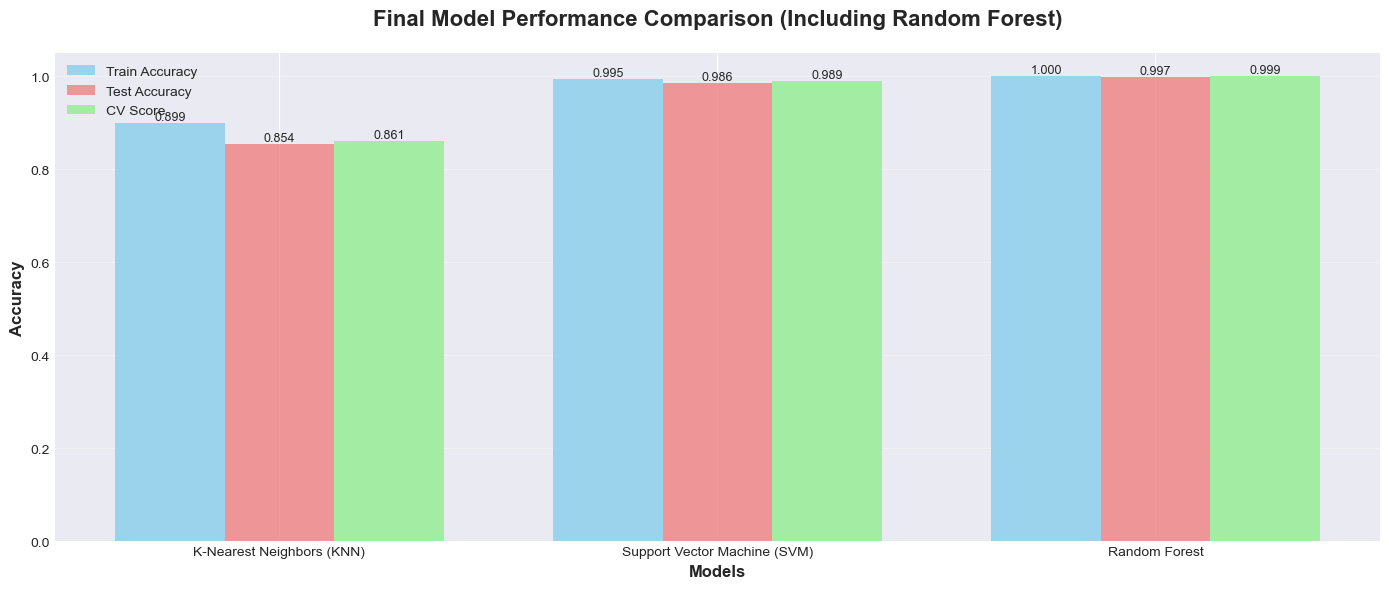


All models trained successfully!


In [19]:
# Example: Adding Random Forest to demonstrate scalability
from sklearn.ensemble import RandomForestClassifier

# Add Random Forest model
models_config.append(
    ModelConfig(
        name='Random Forest',
        model=RandomForestClassifier(random_state=42),
        param_grid={
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
    )
)

print(f"Added Random Forest model. Total models: {len(models_config)}")
print("\nNow running grid search for Random Forest...")

# Run grid search for the new model
model_cfg = models_config[-1]
grid_search = GridSearchCV(
    estimator=model_cfg.model,
    param_grid=model_cfg.param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled_df, y_train)

model_cfg.best_model = grid_search.best_estimator_
model_cfg.best_params = grid_search.best_params_
model_cfg.best_score = grid_search.best_score_

y_pred_test = model_cfg.best_model.predict(X_test_scaled_df)
test_accuracy = accuracy_score(y_test, y_pred_test)

results['Random Forest'] = {
    'best_params': model_cfg.best_params,
    'cv_score': model_cfg.best_score,
    'train_accuracy': accuracy_score(y_train, model_cfg.best_model.predict(X_train_scaled_df)),
    'test_accuracy': test_accuracy,
    'y_pred_test': y_pred_test
}

print(f"\nRandom Forest Results:")
print(f"Best parameters: {model_cfg.best_params}")
print(f"Best CV score: {model_cfg.best_score:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Update comparison visualization
model_names = list(results.keys())
train_accuracies = [results[m]['train_accuracy'] for m in model_names]
test_accuracies = [results[m]['test_accuracy'] for m in model_names]
cv_scores = [results[m]['cv_score'] for m in model_names]

x = np.arange(len(model_names))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width, train_accuracies, width, label='Train Accuracy', alpha=0.8, color='skyblue')
bars2 = ax.bar(x, test_accuracies, width, label='Test Accuracy', alpha=0.8, color='lightcoral')
bars3 = ax.bar(x + width, cv_scores, width, label='CV Score', alpha=0.8, color='lightgreen')

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Final Model Performance Comparison (Including Random Forest)', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("All models trained successfully!")
print("="*80)


In [ ]:
# Test du modèle sauvegardé
import joblib
import pandas as pd
import numpy as np

# Charger le modèle, le scaler et les encodeurs
model = joblib.load('classification_customer_behavior.pkl')
scaler = joblib.load('classification_customer_behavior_scaler.pkl')
encoders = joblib.load('classification_customer_behavior_encoders.pkl')

print("Modèle chargé avec succès!")

# Données de test pour chaque classe
test_cases = [
    {
        'name': 'Occasional Buyers',
        'data': {
            'total_purchases': 2,
            'total_quantity': 5,
            'avg_unit_price': 30.0,
            'total_spent': 150.0,
            'discount_rate': 0.05,
            'customer_lifetime_days': 100,
            'purchase_frequency': 0.02,
            'avg_order_value': 75.0,
            'return_cancel_rate': 0.01,
            'Age': 25,
            'Overall_review': 3.0,
            'Previous Purchases': 1,
            'Gender': 'Female',
            'Preferred_size': 'S',
            'Payment Method': 'Cash',
            'Frequency of Purchases': 'Annually',
        }
    },
    {
        'name': 'Regular Loyalists',
        'data': {
            'total_purchases': 8,
            'total_quantity': 15,
            'avg_unit_price': 40.0,
            'total_spent': 600.0,
            'discount_rate': 0.1,
            'customer_lifetime_days': 200,
            'purchase_frequency': 0.04,
            'avg_order_value': 75.0,
            'return_cancel_rate': 0.05,
            'Age': 35,
            'Overall_review': 4.0,
            'Previous Purchases': 6,
            'Gender': 'Male',
            'Preferred_size': 'M',
            'Payment Method': 'Debit Card',
            'Frequency of Purchases': 'Monthly',
        }
    },
    {
        'name': 'Bargain Hunters',
        'data': {
            'total_purchases': 5,
            'total_quantity': 10,
            'avg_unit_price': 35.0,
            'total_spent': 350.0,
            'discount_rate': 0.7,
            'customer_lifetime_days': 150,
            'purchase_frequency': 0.03,
            'avg_order_value': 70.0,
            'return_cancel_rate': 0.02,
            'Age': 28,
            'Overall_review': 3.5,
            'Previous Purchases': 4,
            'Gender': 'Female',
            'Preferred_size': 'L',
            'Payment Method': 'PayPal',
            'Frequency of Purchases': 'Quarterly',
        }
    },
    {
        'name': 'VIP Shoppers',
        'data': {
            'total_purchases': 20,
            'total_quantity': 40,
            'avg_unit_price': 60.0,
            'total_spent': 2400.0,
            'discount_rate': 0.05,
            'customer_lifetime_days': 400,
            'purchase_frequency': 0.05,
            'avg_order_value': 120.0,
            'return_cancel_rate': 0.01,
            'Age': 45,
            'Overall_review': 5.0,
            'Previous Purchases': 18,
            'Gender': 'Male',
            'Preferred_size': 'XL',
            'Payment Method': 'Credit Card',
            'Frequency of Purchases': 'Weekly',
        }
    },
    {
        'name': 'Problem Customers',
        'data': {
            'total_purchases': 10,
            'total_quantity': 20,
            'avg_unit_price': 50.0,
            'total_spent': 1000.0,
            'discount_rate': 0.2,
            'customer_lifetime_days': 300,
            'purchase_frequency': 0.03,
            'avg_order_value': 100.0,
            'return_cancel_rate': 0.5,
            'Age': 30,
            'Overall_review': 2.0,
            'Previous Purchases': 8,
            'Gender': 'Female',
            'Preferred_size': 'M',
            'Payment Method': 'Bank Transfer',
            'Frequency of Purchases': 'Bi-Weekly',
        }
    }
]

# Fonction pour faire une prédiction
def predict_customer_class(input_data):
    # Features numériques
    numerical_features = [
        'total_purchases', 'total_quantity', 'avg_unit_price', 'total_spent',
        'discount_rate', 'customer_lifetime_days', 'purchase_frequency',
        'avg_order_value', 'return_cancel_rate', 'Age', 'Overall_review',
        'Previous Purchases'
    ]
    cat_features = ['Gender', 'Preferred_size', 'Payment Method', 'Frequency of Purchases']
    
    # Créer DataFrame
    df_input = pd.DataFrame([{k: input_data[k] for k in numerical_features}], columns=numerical_features)
    
    # Encoder les features catégorielles
    for col in cat_features:
        le = encoders[col]
        encoded_col = col + '_encoded'
        try:
            df_input[encoded_col] = le.transform([input_data[col]])
        except ValueError:
            # Si label inconnu, utiliser la première classe
            df_input[encoded_col] = le.transform([le.classes_[0]])
    
    # Convertir en float
    df_input = df_input.astype(float)
    
    # Appliquer le scaling
    df_input = pd.DataFrame(scaler.transform(df_input), columns=df_input.columns, index=df_input.index)
    
    # Prédire
    pred = model.predict(df_input)[0]
    
    # Classes
    class_names = {
        0: 'Occasional Buyers',
        1: 'Regular Loyalists',
        2: 'Bargain Hunters',
        3: 'VIP Shoppers',
        4: 'Problem Customers'
    }
    
    return class_names.get(pred, f'Classe {pred}'), pred

# Tester chaque cas
print("\n" + "="*60)
print("TEST DU MODÈLE DE CLASSIFICATION COMPORTEMENT CLIENT")
print("="*60)

for test_case in test_cases:
    predicted_class, class_num = predict_customer_class(test_case['data'])
    print(f"\nTest: {test_case['name']}")
    print(f"Prédiction: {predicted_class} (Classe {class_num})")
    print("-" * 40)

print("\nTest terminé!")